In [ ]:
# 11 Survival Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

%matplotlib inline

In [ ]:
## 11.8.1 Brain Cancer Data

In [5]:
BrainCancer = pd.read_csv('../data/BrainCancer.csv', header=0)
# use some options in .describe() to get a quick overview of the data
BrainCancer.describe(include = 'object')

,sex,diagnosis,loc,stereo
count,88,87,88,88
unique,2,4,2,2
top,Female,Meningioma,Supratentorial,SRT
freq,45,42,69,65


In [6]:
# create a kmf object
kmf = KaplanMeierFitter() 

In [7]:
# fit the data into the model
kmf.fit(BrainCancer.time, BrainCancer.status,label='Kaplan Meier Estimate')


<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 88 total observations, 53 right-censored observations>

<AxesSubplot: xlabel='timeline'>

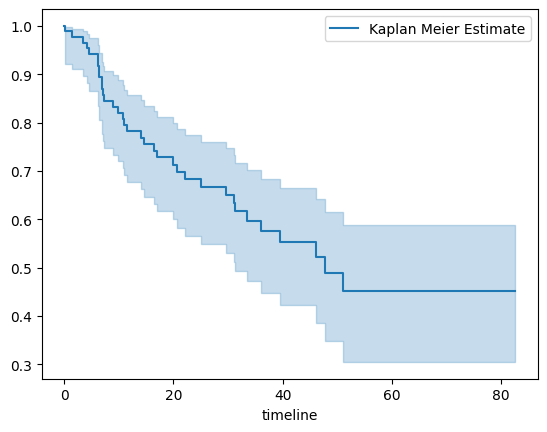

In [8]:
# create an estimate
kmf.plot(ci_show=True) ## ci_show is meant for Confidence interval, which is the shaded area in the plot.

<AxesSubplot: xlabel='timeline'>

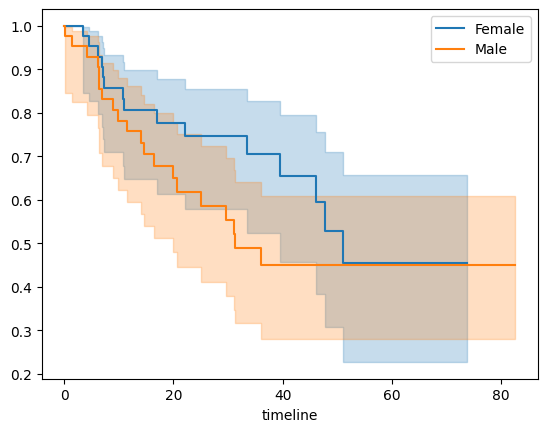

In [9]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## two Cohorts are compared. Cohort 1. Female; Cohort 2. Male 
groups = BrainCancer['sex'] 
T = BrainCancer.time
E = BrainCancer.status  
i1 = (groups == 'Female')     
i2 = (groups == 'Male')     


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Female')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Male')
kmf1.plot(ax=a1)

In [11]:
# we can perform a log-rank test to compare the survival of males to females,
results=logrank_test(T[i1],T[i2],event_observed_A=E[i1], event_observed_B=E[i2])
results.print_summary()
""" 
The resulting p-value is 0.23, indicating no evidence of a difference in sur- vival between the two sexes.
This also can be seen from the overlapping the confidence intervals. 
"""

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

' \nThe resulting p-value is 0.23, indicating no evidence of a difference in sur- vival between the two sexes.\nThis also can be seen from the overlapping the confidence intervals. \n'

In [12]:
df_dummy = pd.get_dummies(BrainCancer, drop_first=True)
df_dummy.head()


,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1


In [13]:
# use Cox Proportional Hazards model
cph1 = CoxPHFitter()   
cph1.fit(df_dummy[['status', 'sex_Male', 'time']], 'time', event_col='status')   
cph1.print_summary()
""" 
I was not able to use the optional 'formula' in the fit() function due to the compatibility with new version, instead I sliced the dataframe to only contains 3 cols ('status', 'sex_Male', 'time')
Here the p value is at 0.233. Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females.
"""

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2022-11-15 02:48:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex_Male    0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

            cmp to    z    p   -log2(p)
covariate                              
sex_Male      0.00 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

" \nI was not able to use the optional 'formula' in the fit() function due to the compatibility with new version, instead I sliced the dataframe to only contains 3 cols ('status', 'sex_Male', 'time')\nHere the p value is at 0.233. Regardless of which test we use, we see that there is no clear evidence for a difference in survival between males and females.\n"

In [14]:
# use Cox Proportional Hazards model and use more features 
cph2 = CoxPHFitter()   
cph2.fit(df_dummy, 'time', event_col='status')   
cph2.print_summary()
""" 
after adjusting for the other predictors, larger values of the Karnofsky index, ki, are associated with lower risk, 
i.e. longer survival.
"""

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -118.41
         time fit was run = 2022-11-15 02:49:14 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
ki                    -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
gtv                    0.04       1.04       0.02            -0.01             0.08                 0.99                 1.08
sex_Male               0.10       1.10       0.36            -0.61             0.80                 0.54                 2.24
diagnosis_LG glioma   -1.09       0.34       0.57            -2.22             0.03                 0.11                 1.03
diagnosis_Meningioma  -2.08       0.12       0.45            -2.97            -1.19                 0.05                 0.30
diagnosis_Other       -1.24       0.29       0.63            -2.46            -0.01                 0.09                 0.99
loc_Supratentorial     0.38       1.46       0.70            -0.99             1.74                 0.37                 5.72
stereo_SRT             0.14       1.15       0.60            -1.03             1.31                 0.36                 3.71

                       cmp to     z      p   -log2(p)
covariate                                            
ki                       0.00 -3.16 <0.005       9.32
gtv                      0.00  1.59   0.11       3.17
sex_Male                 0.00  0.27   0.79       0.35
diagnosis_LG glioma      0.00 -1.90   0.06       4.13
diagnosis_Meningioma     0.00 -4.59 <0.005      17.78
diagnosis_Other          0.00 -1.97   0.05       4.37
loc_Supratentorial       0.00  0.54   0.59       0.76
stereo_SRT               0.00  0.23   0.82       0.29
---
Concordance = 0.79
Partial AIC = 252.82
log-likelihood ratio test = 39.47 on 8 df
-log2(p) of ll-ratio test = 17.93

' \nafter adjusting for the other predictors, larger values of the Karnofsky index, ki, are associated with lower risk, \ni.e. longer survival.\n'

## 11.8.2 Publication Data

In [15]:
Publication = pd.read_csv('../data/Publication.csv', header=0)
Publication.head()

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
0,0,0,1,R01,39876,8.016941,44.016,11.203285,1
1,0,0,1,R01,39876,8.016941,23.494,15.178645,1
2,0,0,1,R01,8171,7.612606,8.391,24.410678,1
3,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
4,0,0,1,Contract,33357,76.517537,16.783,8.607803,1


<AxesSubplot: xlabel='timeline'>

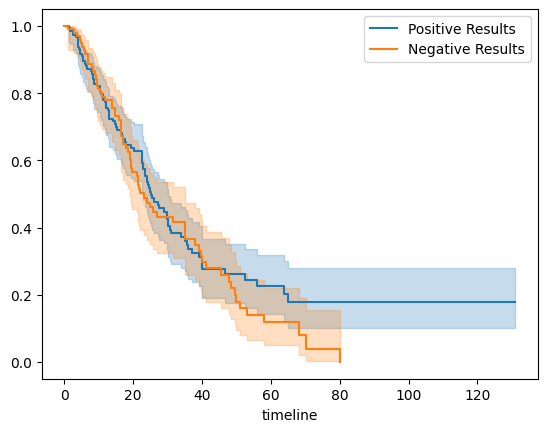

In [16]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## two Cohorts are compared. Cohort 1. posres==0 ; Cohort 2. posres==1
groups = Publication['posres'] 
T = Publication.time
E = Publication.status  
i1 = (groups == 0)     
i2 = (groups == 1)     

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Positive Results')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Negative Results')
kmf1.plot(ax=a1)

In [17]:
# we can perform a log-rank test to compare the survival of positives to negatives,
results=logrank_test(T[i1],T[i2],event_observed_A=E[i1], event_observed_B=E[i2])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.84 0.36      1.48

In [18]:
df_dummy = pd.get_dummies(Publication, drop_first=True)
df_dummy.head()

,posres,multi,clinend,sampsize,budget,impact,time,status,mech_K01,mech_K23,...,mech_P50,mech_R01,mech_R18,mech_R21,"mech_R24, K24",mech_R42,mech_R44,mech_RC2,mech_U01,mech_U54
0,0,0,1,39876,8.016941,44.016,11.203285,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,39876,8.016941,23.494,15.178645,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,8171,7.612606,8.391,24.410678,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,24335,11.771928,15.402,2.595483,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,33357,76.517537,16.783,8.607803,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# use Cox Proportional Hazards model
cph3 = CoxPHFitter()   
cph3.fit(df_dummy[['status', 'posres', 'time']], 'time', event_col='status')   
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2022-11-15 02:52:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.15       1.16       0.16            -0.17             0.46                 0.84                 1.59

            cmp to    z    p   -log2(p)
covariate                              
posres        0.00 0.92 0.36       1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

In [20]:
cph4 = CoxPHFitter()   
cph4.fit(df_dummy[['status', 'posres', 'time', 'multi', 'clinend','sampsize', 'budget', 'impact']], 'time', event_col='status')   
cph4.print_summary()
""" 
After we control for other features, posres becomes an important factor (well, at least significant).
We see that there are a number of statistically significant variables, 
including whether the trial focused on a clinical endpoint (clinend), the impact of the study(impact),
and whether the study had positive or negative results (posres).
"""

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2022-11-15 02:52:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.57       1.77       0.18             0.23             0.92                 1.25                 2.50
multi      -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.57
clinend     0.55       1.73       0.26             0.03             1.06                 1.03                 2.89
sampsize    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
budget      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
impact      0.06       1.06       0.01             0.05             0.07                 1.05                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
posres        0.00  3.24 <0.005       9.73
multi         0.00 -0.16   0.87       0.20
clinend       0.00  2.08   0.04       4.75
sampsize      0.00  0.32   0.75       0.41
budget        0.00  1.78   0.08       3.73
impact        0.00  8.74 <0.005      58.52
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

' \nAfter we control for other features, posres becomes an important factor (well, at least significant).\nWe see that there are a number of statistically significant variables, \nincluding whether the trial focused on a clinical endpoint (clinend), the impact of the study(impact),\nand whether the study had positive or negative results (posres).\n'

## 11.8.3 Call Center Data

In [21]:
np.random.seed(1)
N = 2000
Operators = np.random.choice(range(5, 16), N)
Center = np.random.choice(["A", "B", "C"], N)
Time = np.random.choice(["Morn.", "After.", "Even."], N)

In [22]:
# we generate a similar random data set
X_pre = pd.DataFrame({"Operators": Operators, "Center": Center, "Time": Time})
X = pd.get_dummies(X_pre, drop_first=True)
X.head()

,Operators,Center_B,Center_C,Time_Even.,Time_Morn.
0,10,1,0,0,1
1,13,1,0,0,1
2,14,0,1,0,1
3,10,0,1,0,1
4,5,0,1,1,0


In [23]:
true_coeff = np.array([0.04, -0.3, 0, 0.2, -0.2])
# well, I was not able to fully following the simulation in the book. 
# I think the highlevel idea is to use those coefficients to generate a dataset and show the model fit could 
# sucessfully recover the coefficients.

In [24]:
X['y'] = 350*np.exp(np.sum(-X*true_coeff,axis=1).tolist() + np.random.normal(0, 0.005, N))
X['answered'] = np.where( X['y'] < 300 , 1, 0)
X.head()

,Operators,Center_B,Center_C,Time_Even.,Time_Morn.,y,answered
0,10,1,0,0,1,9.896687e-54,1
1,13,1,0,0,1,8.782572e-54,1
2,14,0,1,0,1,1.424788e-20,1
3,10,0,1,0,1,1.645857e-20,1
4,5,0,1,1,0,4.020516e+24,0


In [ ]:
# use Cox Proportional Hazards model
cph5 = CoxPHFitter()   
cph5.fit(X, 'y', event_col='answered')   
cph5.print_summary()
""" 
Since the simulation is wrong, so the summary is not correct. 
But at least we can see the p-values for Operatator, Center = B, Time = Even. and Time = Morn are very small, 
and they are directly related to the ground truth coefficients.
"""